In [41]:
from __future__ import print_function
from __future__ import division
from collections import defaultdict, OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ujson as json
import logging
import matplotlib.path as mplpath
import os
import calendar
from glob import glob
import dateutil.parser as dparser
import datetime
import logging
from matplotlib_scalebar.scalebar import ScaleBar
import subprocess
import skimage
import skimage.io as skio
from skimage import draw
from skimage import morphology
import time

from optical_vessel_detection.core import ais_utils
from optical_vessel_detection.core import img_utils as iutils
from optical_vessel_detection.core import planet_utils as putils
from optical_vessel_detection.core.annotation_utils import get_labeled_props

from optical_vessel_detection.support.regions import simplified_nk_eez
from optical_vessel_detection.support.regions import approximate_simplified_nk_eez
from optical_vessel_detection.support.regions import full_study_area
from optical_vessel_detection.support.regions import reduced_study_area
from optical_vessel_detection.support import notebook_utils
from optical_vessel_detection.support.notebook_utils import path2sceneid, path2datestr
from optical_vessel_detection.support.info import fully_annotated, aois_by_date
from optical_vessel_detection.support import counting_tools
from optical_vessel_detection.support import detection_metrics

%matplotlib inline

proj_id = os.environ['PROJ_ID']

## Process / Load Info


These instructions are specific to GFW's setup. You will need to adapt this
your specific situation.

In [42]:
scene_map = notebook_utils.create_scene_map(
    f'{proj_id}.machine_learning_production.planet_scene_info')

detections_map = notebook_utils.create_detections_map(
    f'{proj_id}.machine_learning_production.detected_pair_trawlers_1_1_aug')

paths = (
    glob("../../../../image-vessel-identification/data/paper/aoi_annotations_rnd1/*.png")           
  + glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd2/*.tif')
      )

annotations_map = notebook_utils.create_annotations_map(paths, 
                                                      'gs://machine-learning-production/planet_images/nk_detection/',
                                                f'{proj_id}:machine_learning_dev_ttl_120d.annotations_20')

Downloading: 100%|██████████| 4941/4941 [00:00<00:00, 5329.02rows/s]


20170627
20170806
20171024
20180514
20180602
20180715
20180731
20180826
20180911
20180917
20180929
Skipping 20180929_010750_104e
20181008
20181102


## Figure 1E

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


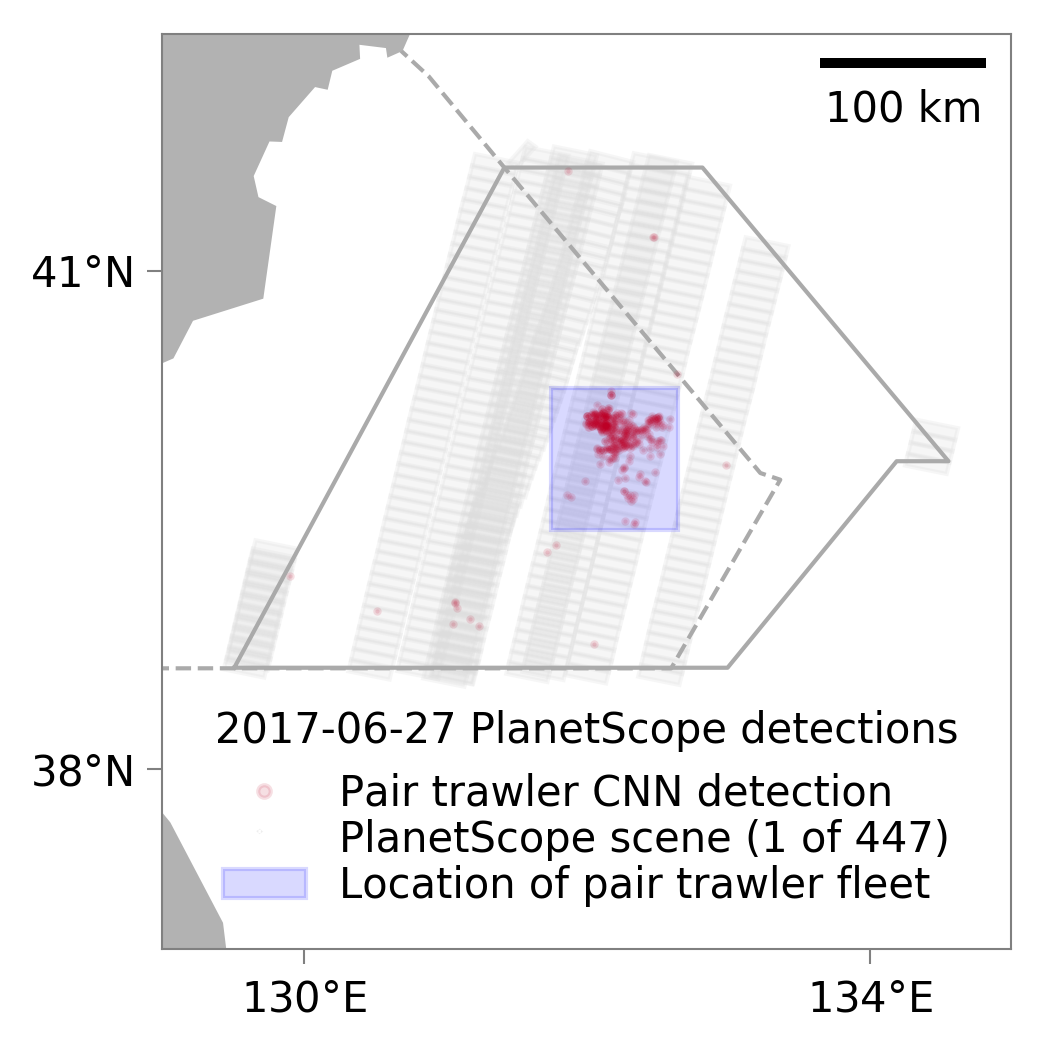

In [43]:
import imp; imp.reload(counting_tools)
from mpl_toolkits.basemap import Basemap

fig, (ax1) = plt.subplots(1, 1, figsize=(3.6,  3.6), dpi=300)
counting_tools.plot_date('20170627', detections_map, scene_map, ax1, 
                             aois=aois_by_date['20170627'], 
                         show_legend='minimal',
                             valid_area=reduced_study_area, show_scalebar=True,
                            show_title=False, font_size=10, 
#                          continent_color="#FFF8DC",
                        scene_legend_offset=(129.69, 37.62))
plt.tight_layout()

In [44]:
## Figure 1B and supplemental material figure

In [45]:
# Also need to plot trawlers in `20180602_012904_0f2d_3B` with only 413170919 and 413170917 overlain and ellipses
# raw = skio.imread('../data/paper/scene_info/20180602_012904_0f2d_3B_Visual.tif')
# straight_img, xform, angle = iutils.straighten_image(raw)
iutils.create_straightened('../data/paper/scene_info/20180602_012904_0f2d_3B_Visual.tif', 
                           '../data/scratch/unmarked_20180602_012904_0f2d_3B_Visual.tif')

In [46]:
L_TO_MINOR = detection_metrics.Detection.L_TO_MINOR
L_TO_MAJOR = detection_metrics.Detection.L_TO_MAJOR

class Detection(detection_metrics.Detection):
    annotations = annotations_map
    detections = detections_map
    
    @classmethod
    def overlay_detections_for_scene_id(cls, img, scene_id, dilations=1):
        img = skimage.img_as_float(img.copy())
        rgb = img[:, :, :3]
        datestr = scene_id.split('_')[0]
        det_for_day = cls.detections[datestr]
        detects = det_for_day[det_for_day.scene_id == scene_id]
        dets = {k : [cls.from_detection(x) for x in detects.itertuples() if x.kind == k] for k in cls.kinds}
        for x in dets['pair_trawlers']:
            x.draw_on(rgb, value=[0.25, 0.25, 0.25], dilations=dilations)
        return img

([], <a list of 0 Text yticklabel objects>)

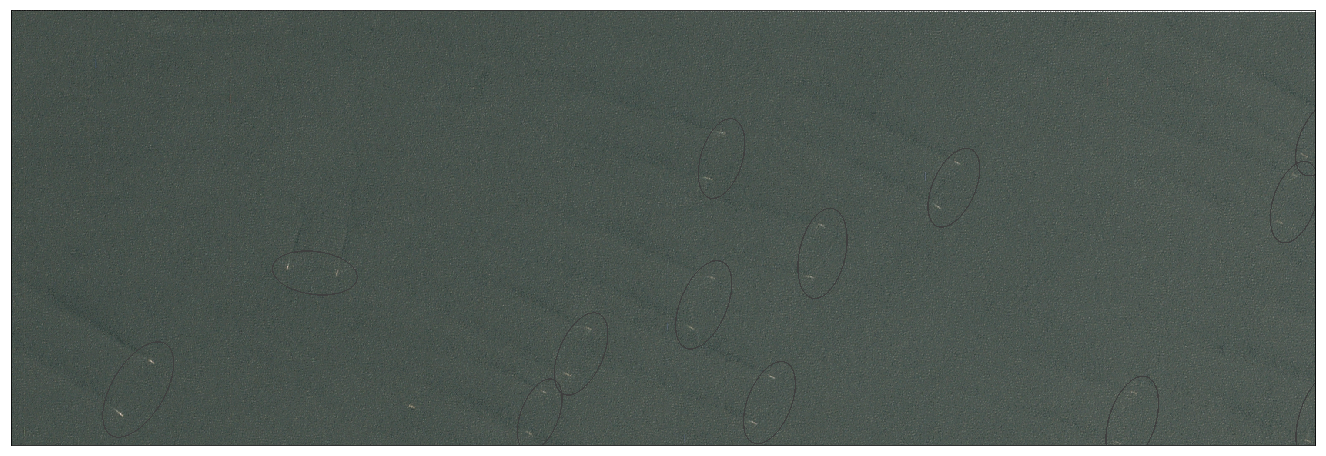

In [47]:
straight_img = skio.imread('../data/scratch/unmarked_20180602_012904_0f2d_3B_Visual.tif')

oval_mask = Detection.overlay_detections_for_scene_id(0 * straight_img, '20180602_012904_0f2d')[:, :, 0]

overlain = Detection.overlay_detections_for_scene_id(straight_img, '20180602_012904_0f2d')
plt.figure(figsize=(24, 8))
plt.imshow(overlain)
plt.xlim(1000, 4000)
plt.ylim(1000, 0)
plt.xticks([])
plt.yticks([])

In [48]:
# Create dummy scene info with scene and lonlat_to_cr then use oais_utils.overlay_ais_on_sceneinfo 
sinfo = iutils.SceneInfo("PATH", overlain, '20180602_012904_0f2d', None,
                         None, None, Detection.lonlat_to_cr('20180602_012904_0f2d'))

In [49]:
metadata = putils.scene_info_from_path('../data/paper/scene_info/20180602_012904_0f2d_3B_Visual_metadata.xml')
ais_df = ais_utils.load_ais_info(metadata,
                                ais_table=f'{proj_id}.pipe_production_v20190502.position_messages_'
                                )

Downloading: 100%|██████████| 33/33 [00:00<00:00, 96.83rows/s]


In [50]:
sinfo = iutils.SceneInfo("PATH",  overlain, '20180602_012904_0f2d', None,
                         None, None, Detection.lonlat_to_cr('20180602_012904_0f2d'))
mask = (ais_df.mmsi == '413170919') | (ais_df.mmsi == '413170917')
new_scene_info, _ = ais_utils.overlay_ais_on_sceneinfo(sinfo, ais_df[mask], fontsize=80)
new_scene_info_all, _ = ais_utils.overlay_ais_on_sceneinfo(sinfo, ais_df, fontsize=36)

/Users/timothyhochberg/Documents/GlobalFishingWatch/Code/paper-dark-fishing-fleets-in-north-korea/supplementary-sections/2-daytime-optical-imagery/optical_vessel_detection/core/ais_utils.py:170: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  rr, cc = draw.circle(r0, c0, 10, shape=scene_shape)
/Users/timothyhochberg/Documents/GlobalFishingWatch/Code/paper-dark-fishing-fleets-in-north-korea/supplementary-sections/2-daytime-optical-imagery/optical_vessel_detection/core/ais_utils.py:174: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  rr, cc = draw.circle(r, c, 10, shape=scene_shape)
/Users/timothyhochberg/Documents/GlobalFishingWatch/Code/paper-dark-fishing-fleets-in-north-korea/supplementary-sections/2-daytime-optical-imagery/optical_vessel_detection/core/ais_utils.py:188: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  rr, cc = draw.circle(r, c, 7, s

([], <a list of 0 Text yticklabel objects>)

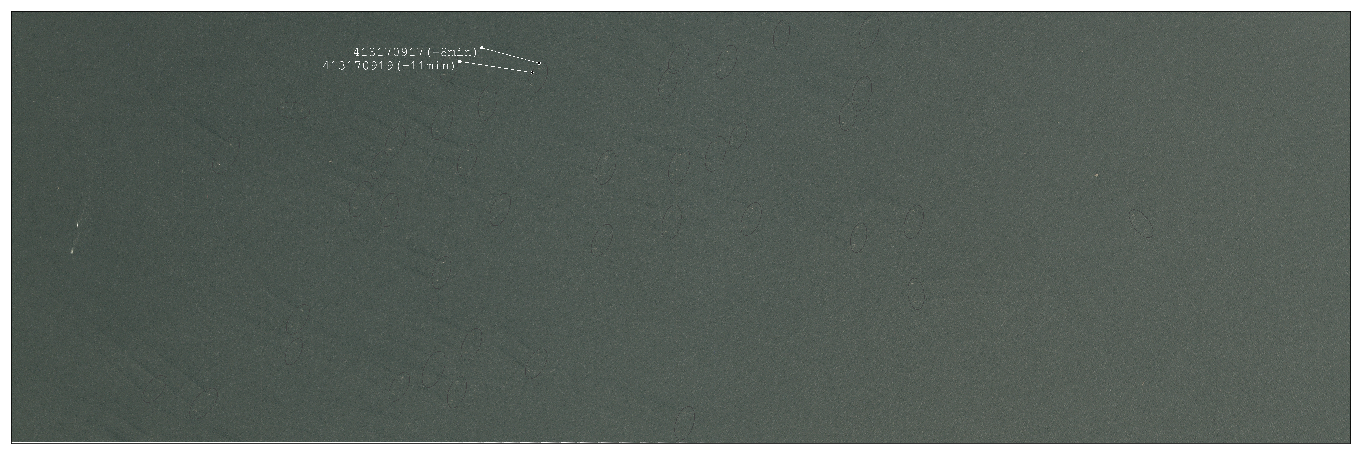

In [51]:
plt.figure(figsize=(24, 8))
plt.imshow(new_scene_info.scene)
# plt.xlim(0, 4000)
# plt.ylim(1500, 0)
plt.xticks([])
plt.yticks([])